## **Course Project: Text Classification with Rakuten France Product Data**

The project focuses on the topic of large-scale product type code text classification where the goal is to predict each product’s type code as defined in the catalog of Rakuten France. This project is derived from a data challenge proposed by Rakuten Institute of Technology, Paris. Details of the data challenge is [available in this link](https://challengedata.ens.fr/challenges/35).

The above data challenge focuses on multimodal product type code classification using text and image data. **For this project we will work with only text part of the data.**

Please read carefully the description of the challenge provided in the above link. **You can disregard any information related to the image part of the data.**

### To obtain the data
You have to register yourself [in this link](https://challengedata.ens.fr/challenges/35) to get access to the data.

For this project you will only need the text data. Download the training files `x_train` and `y_train`, containing the item texts, and the corresponding product type code labels.

### Pandas for handling the data
The files you obtained are in CSV format. We strongly suggest to use Python Pandas package to load and visualize the data. [Here is a basic tutorial](https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/) on how to handle data in CSV file using Pandas.

If you open the `x_train` dataset using Pandas, you will find that it contains following columns:
1. an integer ID for the product
2. **designation** - The product title
3. description
4. productid
5. imageid

For this project we will only need the integer ID and the designation. You can [`drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) the other columns.

The training output file `y_train.csv` contains the **prdtypecode**, the target/output variable for the classification task, for each integer id in the training input file `X_train.csv`.

### Task for the break
1. Register yourself and download the training and test for text data. You do not need the `supplementary files` for this project.
2. Load the data using pandas and disregard unnecessary columns as mentioned above.
3. On the **designation** column, apply the preprocessing techniques.

### Task for the end of the course
After this preprocessing step, you have now access to a TF-IDF matrix that constitute our data set for the final evaluation project. The project guidelines are:
1. Apply all approaches taught in the course and practiced in lab sessions (Decision Trees, Bagging, Random forests, Boosting, Gradient Boosted Trees, AdaBoost, etc.) on this data set. The goal is to predict the target variable (prdtypecode).
2. Compare performances of all these models in terms of the weighted-f1 scores you can output. 
3. Conclude about the most appropriate approach on this data set for the predictive task. 
4. Write a report in .tex format that adress all these guidelines with a maximal page number of 5 (including figures, tables and references). We will take into account the quality of writing and presentation of the report.

In [0]:
! pip install spacy
! pip install spacy_langdetect
! pip install en_core_web_sm
! pip install spacy_langdetect
! python -m spacy download fr_core_news_md
! python -m spacy download fr_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import spacy
from spacy_langdetect import LanguageDetector
from spacy.tokens import Token
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [0]:
#To visualise the whole row in a df.head()
pd.set_option('display.max_colwidth', -1)

In [0]:
X_train = pd.read_csv('/content/drive/Shared drives/Ensemble Learning/data/X_train_update.csv')
y_train = pd.read_csv('/content/drive/Shared drives/Ensemble Learning/data/Y_train_CVw08PX.csv')
X_test = pd.read_csv('/content/drive/Shared drives/Ensemble Learning/data/X_test_update.csv')

In [0]:
X_train.drop(X_train[['description','productid','imageid']],axis=1, inplace=True)
X_test.drop(X_test[['description','productid','imageid']],axis=1, inplace=True)

### **Binding x_train and y_train**

In [0]:
X_train['y_train']=y_train['prdtypecode']

# **Preprocessing**

### **Keeping 10% of the data for a faster code**

In [0]:
X_train_reduced = X_train # to run everything using the whole dataset

### **Lower Case**

In [0]:
X_train_reduced['designation'] = X_train_reduced['designation'].str.lower()

### **Removing NonAlphabetic Characters**

In [0]:
def remove_characters(string):
    string = re.sub("([^\w]|[\d_])+", " ",  string)
    return string

In [0]:
X_train_reduced['designation'] = X_train_reduced['designation'].apply(remove_characters)

### **Language Detection**

##### Language Identification

In [0]:
import fr_core_news_sm
import en_core_web_sm

language_detector = LanguageDetector()

nlp_fr = fr_core_news_sm.load(disable=["tagger", "parser","ner","entity_linker","textcat","entity_ruler","sentencizer","merge_noun_chunks","merge_entities","merge_subtokens"])
nlp_fr.add_pipe(nlp_fr.create_pipe('sentencizer'))
nlp_fr.add_pipe(language_detector)


In [0]:
import time
start_time = time.time()
X_train_reduced['language'] = X_train_reduced['designation'].str[:].apply(lambda row : nlp_fr(row)._.language['language'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 720.8417634963989 seconds ---


In [0]:
from google.colab import files
X_train_reduced.to_csv('data_train_languages.csv') 
files.download('data_train_languages.csv')

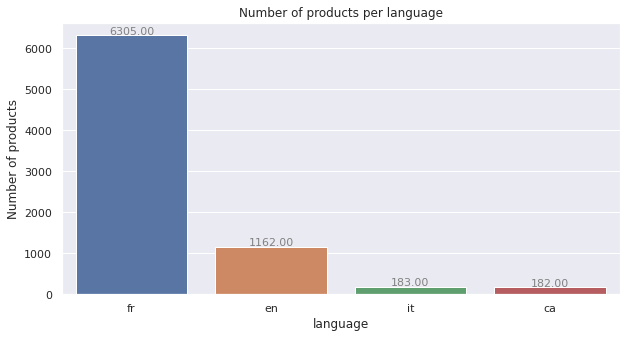

In [0]:
fig, axes = plt.subplots(1, 1, figsize = (10,5))

ax = sns.countplot(x="language", 
                   data=X_train_reduced,
                   order=['fr','en','it','ca']
                     )
ax.set(xlabel='language', ylabel='Number of products', title='Number of products per language')

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), 
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=11, color='gray', xytext=(0, 4),
    textcoords='offset points')
    
plt.show()

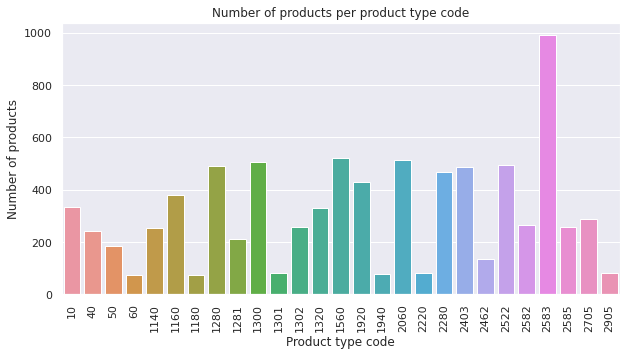

In [0]:
fig, axes = plt.subplots(1, 1, figsize = (10,5))

ax = sns.countplot(x="y_train", 
                   data=X_train_reduced
                   #order=['fr','en','it','ca']
                     )
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel='Product type code', ylabel='Number of products', title='Number of products per product type code')

plt.show()

##### **Top 2 languages**


We can focus our analysis on the 2 most frequent languages : 
- French
- English


In [0]:
X_train_reduced['language'].value_counts().head()

fr    6305
en    1162
it    183 
ca    182 
ro    93  
Name: language, dtype: int64

### **Or Directly load the Data**

In [0]:
X_train_reduced=pd.read_csv("/content/drive/Shared drives/Ensemble Learning/data_train_languages.csv")

### **Tokenizing**

In [0]:
import fr_core_news_md
import en_core_web_sm

nlp_fr = fr_core_news_md.load(disable=["tagger", "parser","ner","entity_linker","textcat","entity_ruler","sentencizer","merge_noun_chunks","merge_entities","merge_subtokens"])
nlp_en = en_core_web_sm.load(disable=["tagger", "parser","ner","entity_linker","textcat","entity_ruler","sentencizer","merge_noun_chunks","merge_entities","merge_subtokens"])

In [0]:
languages_model={'fr':nlp_fr,'en':nlp_en}

In [0]:
def tokenize(row):
    return [token.orth_ for token in row]

In [0]:
def recombining_tokens_into_a_string(list_of_tokens):
    return " ".join(list_of_tokens)

In [0]:
X_train_reduced.head()

,Unnamed: 0,Unnamed: 0.1,designation,y_train,language
0,0,0,olivia personalisiertes notizbuch seiten punktraster ca din a rosen design,10,it
1,1,1,journal des arts le n du l art et son marche salon d art asiatique a paris jacques barrere francois perrier la reforme des ventes aux encheres publiques le sna fete ses cent ans,2280,fr
2,2,2,grand stylet ergonomique bleu gamepad nintendo wii u speedlink pilot style,50,no
3,3,3,peluche donald europe disneyland marionnette à doigt,1280,fr
4,4,4,la guerre des tuques,2705,ca


In [0]:
def preprocess(language_model,X_train):
  X_train_final=X_train[~(X_train['language'].isin(list(languages_model.keys())))]
  X_train_final['designation_final']=X_train_final['designation']
  for language in languages_model.keys():
    X_train_lang=X_train.loc[X_train['language'] == language ] # subset the dataframe for the specific language
    spacy_tokens = X_train_lang['designation'].apply(languages_model[language]) #Define spacy model
    #####token_lang = spacy_tokens.apply(tokenize) # Tokenize
    token_lang=spacy_tokens.apply(lambda x: [token.lemma_ for token in x if not token.is_stop]) # Extract lemmas and remove stop words
    X_train_lang['designation_final'] = token_lang.apply(recombining_tokens_into_a_string)
    X_train_final=pd.concat([X_train_final,X_train_lang],axis=0)
  return X_train_final

In [0]:
X_train_prepro=preprocess(languages_model,X_train_reduced)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
X_train_prepro.head()

,Unnamed: 0,Unnamed: 0.1,designation,y_train,language,designation_final
0,0,0,olivia personalisiertes notizbuch seiten punktraster ca din a rosen design,10,it,olivia personalisiertes notizbuch seiten punktraster ca din a rosen design
2,2,2,grand stylet ergonomique bleu gamepad nintendo wii u speedlink pilot style,50,no,grand stylet ergonomique bleu gamepad nintendo wii u speedlink pilot style
4,4,4,la guerre des tuques,2705,ca,la guerre des tuques
6,6,6,christof e bildungsprozessen auf der spur,10,de,christof e bildungsprozessen auf der spur
8,8,8,puzzle scooby doo avec poster x pieces,1280,ro,puzzle scooby doo avec poster x pieces


### **Removing Accents**

In [0]:
def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('â', 'a')

    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')

    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')
    
    return string

In [0]:
X_train_prepro['designation_final'] = X_train_prepro['designation_final'].apply(normalize_accent)

# **Vector Space Model**

In [0]:
#import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#create a TfidfVectorizer object
tfidf = TfidfVectorizer()

#Vectorize the sample text
X_train_set = tfidf.fit_transform(X_train_prepro['designation_final'])

print("Shape of the TF-IDF Matrix:")
print(X_train_set.shape)
print("TF-IDF Matrix:")

Shape of the TF-IDF Matrix:
(84916, 54174)
TF-IDF Matrix:


We will use this Tf_idf matrix to classify each of ours products.

# **Models**

In [0]:
#Number of categories to classify
print("there are ",y_train['prdtypecode'].nunique()," categories to classify")

there are  27  categories to classify


In [0]:
#all the categories 
y_train['prdtypecode'].unique()

array([  10, 2280,   50, 1280, 2705, 2522, 2582, 1560, 1281, 1920, 2403,
       1140, 2583, 1180, 1300, 2462, 1160, 2060,   40,   60, 1320, 1302,
       2220, 2905, 2585, 1940, 1301])

In [0]:
#Let's rename ours elements to train the model. It will make it more clear.
y_train_set=X_train_prepro['y_train']

### **Define metrics**

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, average="weighted")

### **Decision Tree**

In [0]:
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

##### Training

In [0]:
clf_dec_tree = tree.DecisionTreeClassifier() 
cv_results_dec_tree = cross_validate(clf_dec_tree, X_train_set,y_train_set , cv=5,scoring=f1_scorer) 

##### *Results*

In [0]:
cv_results_dec_tree['test_score'].mean()

0.5588130897412846

### **Decision Tree GridSearch**

##### *Choice of hyperparameters*

In [0]:
# Set the parameters for grid_search
criterion = ['gini', 'entropy'] #(default gini)
max_depth = [50,100,150] # (default None)
min_samples_leaf=[1,2,3] # (default one)
tuned_parameters_dec_tree = [{'criterion': criterion, 'max_depth':max_depth}]

##### *Training*

In [0]:
grid_dec_tree = GridSearchCV(
    tree.DecisionTreeClassifier() , tuned_parameters_dec_tree,cv=5,scoring=f1_scorer
  )
result=grid_dec_tree.fit(X_train_set,y_train_set)

##### *Results*

In [0]:
print(result.best_params_)
print(result.best_score_)

{'criterion': 'gini', 'max_depth': None}
0.5615045235697922


### **Random Forest with Grid Search**

In [0]:
from sklearn.ensemble import RandomForestClassifier

##### *Choice of hyperparameters*

In [0]:
# Set the parameters for grid_search
n_estimators=[100,140] #(default 100)
random_state = [50] # (default None)
max_depth = [50,100,150] # (default None)
n_jobs=[-1]
tuned_parameters_rf = [{'random_state': random_state, 'max_depth':max_depth,'n_jobs':n_jobs}]

##### *Training*

In [0]:
import time
start_time = time.time()
grid_random_forest = GridSearchCV(
    RandomForestClassifier() , tuned_parameters_rf,cv=5,scoring=f1_scorer
  )
result_rf=grid_random_forest.fit(X_train_set,y_train_set)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1328.270412683487 seconds ---


##### *Results*

In [0]:
print(result_rf.best_params_)
print(result_rf.best_score_)

{'max_depth': None, 'n_jobs': -1, 'random_state': None}
0.7638016614710016


### **Adaboost with Grid Search**

In [0]:
from sklearn.ensemble import AdaBoostClassifier

##### *Choice of hyperparameters*

In [0]:
# Set the parameters for grid_search
# Set the parameters for grid_search
random_state = [50] #add more parameters here (default None)
n_estimators = [50,100] #add more parameters here (default 50)
learning_rate=[1,0.1,0.01]
tuned_parameters_ada = [{'random_state': random_state, 'n_estimators':n_estimators,'learning_rate':learning_rate}]

##### *Training*

In [0]:
grid_ada = GridSearchCV(
    
    
    AdaBoostClassifier(), tuned_parameters_ada,cv=5,scoring=f1_scorer
  )
result_ada=grid_ada.fit(X_train_set,y_train_set)

##### *Results*

In [0]:
print(result_ada.best_params_)
print(result_ada.best_score_)

### **XGboost with GridSearch**

In [0]:
from xgboost import XGBClassifier

##### *Choice of hyperparameters*

In [0]:
# Set the parameters for grid_search
max_depth = [3,4,5] #add more parameters here (default 3)
n_estimators = [50,100,120] #add more parameters here (default 100)
nthread=[-1]
n_jobs=[-1]
tuned_parameters_xgb = [{'max_depth': max_depth, 'n_estimators':n_estimators,'nthread':nthread,'n_jobs':n_jobs}]

##### *Training*

In [0]:
start_time = time.time()
grid_xgb = GridSearchCV(
    XGBClassifier(), tuned_parameters_xgb,cv=5,scoring=f1_scorer
  )
result_xgb=grid_xgb.fit(X_train_set,y_train_set)
print("--- %s seconds ---" % (time.time() - start_time))

--- 290.4972712993622 seconds ---


##### *Results*

In [0]:
print(result_xgb.best_params_)
print(result_xgb.best_score_)

{'max_depth': 3, 'n_estimators': 100, 'n_jobs': -1, 'nthread': -1}
0.560033249837717
